  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  285k  100  285k    0     0   745k      0 --:--:-- --:--:-- --:--:--  760k


{1: ' ', 2: "'", 3: 'A', 4: 'B', 5: 'C', 6: 'D', 7: 'E', 8: 'F', 9: 'G', 10: 'H', 11: 'I', 12: 'J', 13: 'K', 14: 'L', 15: 'M', 16: 'N', 17: 'O', 18: 'P', 19: 'Q', 20: 'R', 21: 'S', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z', 29: 'Ã', 30: '‘', 31: '‡', 0: '.'}
torch.Size([233710, 5]) torch.Size([233710])
torch.Size([29379, 5]) torch.Size([29379])
torch.Size([28894, 5]) torch.Size([28894])
Xtr max: 31, Xtr min: 0, C shape: 27
DENNIS DANIEL AL
ONASTXAN.
CLAUDIU ANGEL JO
GINSTIN.
LUCENO.
MARIANO.
VICENTE.
MAEDH MIGUEL MAN
SENRIL.
MERDIAN ALEXANDE
NANOMD.
ALFREDO JUAN.
MIGUEL.
RAUL MARCOS JESU
SANTIAGO.
JOHN MANUEL.
ANTONIO.
ANDREW.
OSCAR.
ROBERTO JUAN.


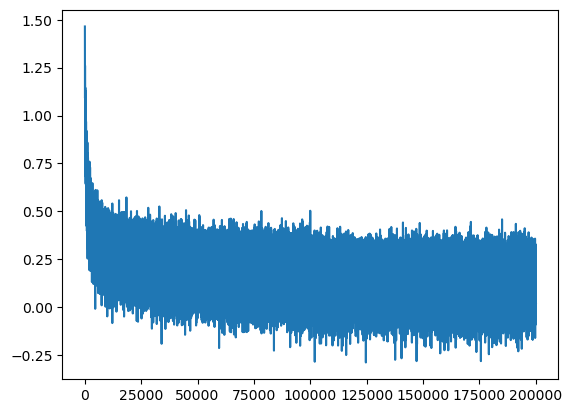

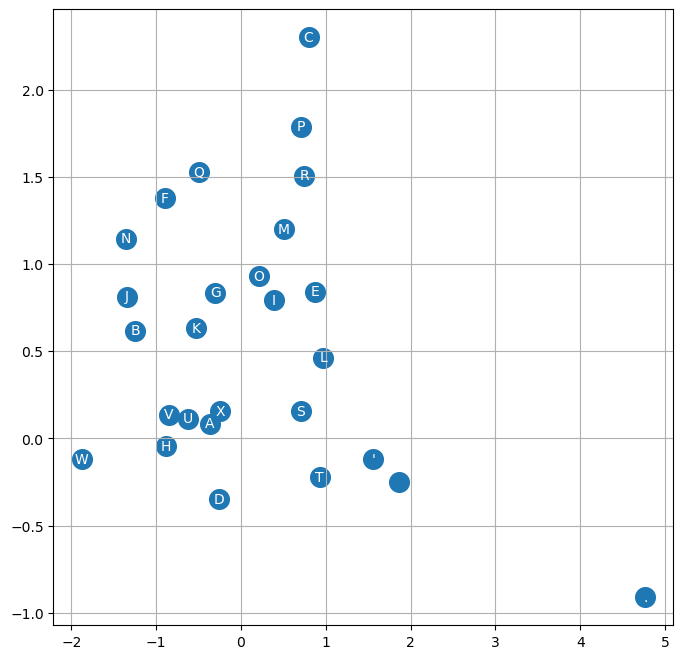

In [20]:
# Spanish model - Character-based name generator using neural networks
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# Download dataset from GitHub and load it into a list of words
# This dataset contains Spanish names that will be used to train the model
!curl -o Ex2sample.csv https://raw.githubusercontent.com/AntonioCorderoBrummer/Ex2-sample/refs/heads/main/Ex2sample.csv
words = open('Ex2sample.csv', 'r').read().splitlines()

# Create a sorted list of unique characters appearing in the dataset
# This ensures the model only learns valid characters present in the dataset
chars = sorted(list(set(''.join(words))))
# Create a mapping from characters to indices (stoi) and indices to characters (itos)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0  # Assign 0 to the end-of-word marker, which helps in generating names
itos = {i:s for s,i in stoi.items()}
print(itos)

block_size = 5 # Number of previous characters used as context (trigram model)

# Function to build the dataset (X: input context, Y: target character)
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size  # Initialize context with padding (0s) to allow generation from the beginning
    for ch in w + '.':  # Append a '.' at the end of each word to indicate termination
      ix = stoi[ch]  # Convert character to index
      X.append(context)  # Store current context as input
      Y.append(ix)  # Store next character as the target output
      context = context[1:] + [ix]  # Update context by shifting left, maintaining window size

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)  # Print dataset dimensions
  return X, Y

import random
random.seed(42)
random.shuffle(words)  # Shuffle words to randomize training data order
n1 = int(0.8*len(words))  # 80% for training
n2 = int(0.9*len(words))  # 10% for validation, 10% for test

# Split dataset into training, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Initialize model parameters
g = torch.Generator().manual_seed(2147483647)  # Set a fixed seed for reproducibility
C = torch.randn((27, 10), generator=g)  # Character embedding matrix: 27 characters mapped to 10 dimensions
W1 = torch.randn((block_size * C.shape[1], 200), generator=g)  # First layer weights: Maps embeddings to 200 neurons
b1 = torch.randn(200, generator=g)  # First layer biases
W2 = torch.randn((200, 27), generator=g)  # Second layer weights: Outputs probabilities for 27 characters
b2 = torch.randn(27, generator=g)  # Second layer biases
parameters = [C, W1, b1, W2, b2]  # Store all model parameters in a list for easy manipulation

# Enable gradients for training
for p in parameters:
  p.requires_grad = True  # Allow PyTorch to track gradients for optimization

lre = torch.linspace(-3, 0, 1000)  # Learning rate exploration range (log scale)
lrs = 10**lre  # Convert to logarithmic scale
lri = []
lossi = []
stepi = []

# Training loop
for i in range(200000):
  ix = torch.randint(0, Xtr.shape[0], (32,))  # Sample 32 random training examples per batch
  
  emb = C[Xtr[ix].clamp(0, C.shape[0] - 1)]  # Retrieve embeddings, ensuring valid indices
  h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
  # Apply first layer transformation with tanh activation
  logits = h @ W2 + b2  # Compute logits for predicting the next character
  loss = F.cross_entropy(logits, Ytr[ix].clamp(0, C.shape[0] - 1))  # Compute loss (categorical cross-entropy)

  for p in parameters:
    p.grad = None  # Reset gradients before each backpropagation step
  loss.backward()  # Compute gradients using backpropagation
  
  lr = 0.1 if i < 100000 else 0.01  # Adjust learning rate dynamically (higher initially, lower later)
  for p in parameters:
    p.data += -lr * p.grad  # Update parameters using gradient descent

  stepi.append(i)
  lossi.append(loss.log10().item())  # Store loss for visualization

plt.plot(stepi, lossi)  # Plot training loss over time

# Model evaluation
print(f"Xtr max: {Xtr.max()}, Xtr min: {Xtr.min()}, C shape: {C.shape[0]}")

# Evaluate training performance
emb = C[Xtr.clamp(0, C.shape[0] - 1)]
h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr.clamp(0, C.shape[0] - 1))
loss

# Evaluate validation performance
emb = C[Xdev.clamp(0, C.shape[0] - 1)]
h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev.clamp(0, C.shape[0] - 1))
loss

# Evaluate test performance
emb = C[Xte.clamp(0, C.shape[0] - 1)]
h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte.clamp(0, C.shape[0] - 1))
loss

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Name generation loop - generates 20 names
for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits / 0.7, dim=1)  # Adjust temperature to control randomness
        ix = torch.multinomial(probs, num_samples=1).item()  # Sample next character probabilistically
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0 or len(out) > 15:  # Stop generation if '.' is reached or name is too long
            break
    
    print(''.join(itos[i] for i in out))  # Convert indices back to characters and print name


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 81 18733   81 15158    0     0  56034      0 --:--:-- --:--:-- --:--:-- 57200
100 18733  100 18733    0     0  69006      0 --:--:-- --:--:-- --:--:-- 70424


{1: ' ', 2: 'A', 3: 'B', 4: 'C', 5: 'D', 6: 'E', 7: 'F', 8: 'G', 9: 'H', 10: 'I', 11: 'J', 12: 'K', 13: 'L', 14: 'M', 15: 'N', 16: 'O', 17: 'P', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'Y', 25: 'a', 26: 'b', 27: 'c', 28: 'd', 29: 'e', 30: 'f', 31: 'g', 32: 'h', 33: 'i', 34: 'j', 35: 'k', 36: 'l', 37: 'm', 38: 'n', 39: 'o', 40: 'p', 41: 'q', 42: 'r', 43: 's', 44: 't', 45: 'u', 46: 'v', 47: 'w', 48: 'y', 49: 'z', 0: '.'}
torch.Size([15003, 4]) torch.Size([15003])
torch.Size([1861, 4]) torch.Size([1861])
torch.Size([1869, 4]) torch.Size([1869])
Matilde.
Ingomar.
Hermann.
Berna.
Rothard.
Fenja.
Herbrand.
Richmann.
Evke.
Heilmut.
Nord.
Bernhard.
Osmar.
Rainard.
Mira.
Raimo.
Ragna.
Gerbrand.
Sungard.
Herwald.


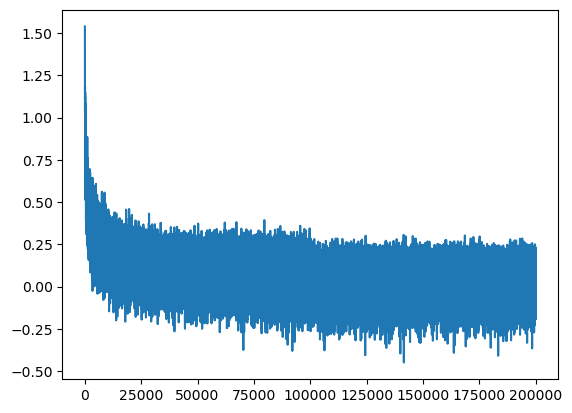

In [21]:
# German model - Character-based name generator using neural networks
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# Download dataset from GitHub and load it into a list of words
# This dataset contains German names that will be used to train the model
!curl -o german_names.csv https://raw.githubusercontent.com/AntonioCorderoBrummer/Ex2-sample/refs/heads/main/german_.male_name.csv
words = open('german_names.csv', 'r').read().splitlines()

# Normalize special characters to ensure consistency
# This is useful if you want to avoid encoding issues with German characters
words = [w.replace("ä", "a").replace("ö", "o").replace("ü", "u").replace("ß", "ss") for w in words]

# Extract unique characters from the dataset and create mappings
chars = sorted(list(set(''.join(words))))  # Get unique characters from all names
stoi = {s:i+1 for i,s in enumerate(chars)}  # Mapping from characters to indices
stoi['.'] = 0  # Assign 0 to the end-of-word marker
itos = {i:s for s,i in stoi.items()}  # Reverse mapping from indices to characters
print(itos)

block_size = 4  # Number of previous characters used as context (4-gram model)

# Function to build the dataset (X: input context, Y: target character)
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # Initialize context with padding (0s)
        for ch in w + '.':  # Append '.' at the end of each word to indicate termination
            ix = stoi[ch]  # Convert character to index
            X.append(context)  # Store current context as input
            Y.append(ix)  # Store next character as the target output
            context = context[1:] + [ix]  # Update context by shifting left, maintaining window size
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)  # Print dataset dimensions
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # Shuffle words to randomize training data order
n1 = int(0.8*len(words))  # 80% for training
n2 = int(0.9*len(words))  # 10% for validation, 10% for test

# Split dataset into training, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Initialize model parameters
g = torch.Generator().manual_seed(2147483647)  # Set a fixed seed for reproducibility
C = torch.randn((len(chars) + 1, 10), generator=g)  # Character embedding matrix
W1 = torch.randn((block_size * 10, 200), generator=g)  # First layer weights
b1 = torch.randn(200, generator=g)  # First layer biases
W2 = torch.randn((200, len(chars) + 1), generator=g)  # Second layer weights
b2 = torch.randn(len(chars) + 1, generator=g)  # Second layer biases
parameters = [C, W1, b1, W2, b2]  # Store all model parameters in a list for easy manipulation

# Enable gradients for training
for p in parameters:
    p.requires_grad = True  # Allow PyTorch to track gradients for optimization

lre = torch.linspace(-3, 0, 1000)  # Learning rate exploration range (log scale)
lrs = 10**lre  # Convert to logarithmic scale
lri = []
lossi = []
stepi = []

# Training loop
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Sample 32 random training examples per batch
    emb = C[Xtr[ix].clamp(0, C.shape[0] - 1)]  # Retrieve embeddings, ensuring valid indices
    h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1)  # Apply first layer transformation with tanh activation
    logits = h @ W2 + b2  # Compute logits for predicting the next character
    loss = F.cross_entropy(logits, Ytr[ix].clamp(0, C.shape[0] - 1))  # Compute loss (categorical cross-entropy)

    for p in parameters:
        p.grad = None  # Reset gradients before each backpropagation step
    loss.backward()  # Compute gradients using backpropagation
    
    lr = 0.1 if i < 100000 else 0.01  # Adjust learning rate dynamically (higher initially, lower later)
    for p in parameters:
        p.data += -lr * p.grad  # Update parameters using gradient descent

    stepi.append(i)
    lossi.append(loss.log10().item())  # Store loss for visualization

plt.plot(stepi, lossi)  # Plot training loss over time

# Name generation loop - generates 20 names
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # Start with empty context
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits / 0.7, dim=1)  # Adjust temperature to control randomness
        ix = torch.multinomial(probs, num_samples=1).item()  # Sample next character probabilistically
        context = context[1:] + [ix]  # Update context with new character
        out.append(ix)
        if ix == 0 or len(out) > 12:  # Stop generation if '.' is reached or name is too long
            break
    
    print(''.join(itos[i] for i in out))  # Convert indices back to characters and print name

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18733  100 18733    0     0  66349      0 --:--:-- --:--:-- --:--:-- 68120


{1: ' ', 2: 'A', 3: 'B', 4: 'C', 5: 'D', 6: 'E', 7: 'F', 8: 'G', 9: 'H', 10: 'I', 11: 'J', 12: 'K', 13: 'L', 14: 'M', 15: 'N', 16: 'O', 17: 'P', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'Y', 25: 'a', 26: 'b', 27: 'c', 28: 'd', 29: 'e', 30: 'f', 31: 'g', 32: 'h', 33: 'i', 34: 'j', 35: 'k', 36: 'l', 37: 'm', 38: 'n', 39: 'o', 40: 'p', 41: 'q', 42: 'r', 43: 's', 44: 't', 45: 'u', 46: 'v', 47: 'w', 48: 'y', 49: 'z', 0: '.'}
torch.Size([15003, 4]) torch.Size([15003])
torch.Size([1861, 4]) torch.Size([1861])
torch.Size([1869, 4]) torch.Size([1869])
Heinradu.
Rochwald.
Roderich.
Burga.
Irmina.
Richwin.
fried.
Feddo.
Garlinde.
Landhold.
Blid.
Gunthild.
Rut.
Helmut.
Gerlinde.
Ello.
RodewaldIda.
Bernhard.
Ergart.
Malvin.


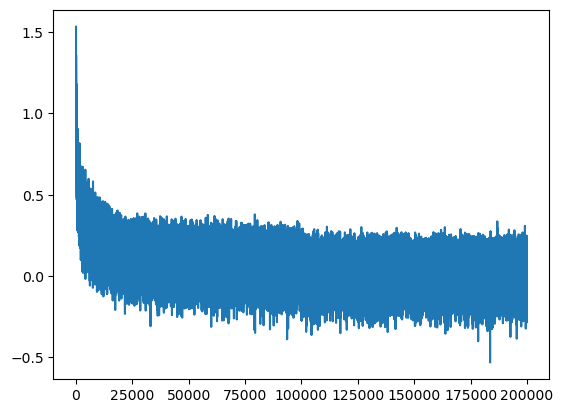

In [22]:
# Spanish model modified to generate German names
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# Download dataset from GitHub and load it into a list of words
# This dataset contains German names that will be used to train the Spanish model
!curl -o Ex2sample.csv https://raw.githubusercontent.com/AntonioCorderoBrummer/Ex2-sample/refs/heads/main/german_.male_name.csv
words = open('Ex2sample.csv', 'r').read().splitlines()

# Normalize German special characters to standard Latin characters
# This helps avoid encoding issues and ensures consistency in training
table = str.maketrans("äöüß", "aous")
words = [w.translate(table) for w in words]

# Extract unique characters from the dataset and create mappings
chars = sorted(list(set(''.join(words))))  # Get unique characters from all names
stoi = {s:i+1 for i,s in enumerate(chars)}  # Mapping from characters to indices
stoi['.'] = 0  # Assign 0 to the end-of-word marker
itos = {i:s for s,i in stoi.items()}  # Reverse mapping from indices to characters
print(itos)

block_size = 4  # Number of previous characters used as context (4-gram model)

# Function to build the dataset (X: input context, Y: target character)
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # Initialize context with padding (0s)
        for ch in w + '.':  # Append '.' at the end of each word to indicate termination
            ix = stoi[ch]  # Convert character to index
            X.append(context)  # Store current context as input
            Y.append(ix)  # Store next character as the target output
            context = context[1:] + [ix]  # Update context by shifting left, maintaining window size
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)  # Print dataset dimensions
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # Shuffle words to randomize training data order
n1 = int(0.8*len(words))  # 80% for training
n2 = int(0.9*len(words))  # 10% for validation, 10% for test

# Split dataset into training, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Initialize model parameters
g = torch.Generator().manual_seed(2147483647)  # Set a fixed seed for reproducibility
C = torch.randn((len(chars) + 1, 10), generator=g)  # Character embedding matrix
W1 = torch.randn((block_size * 10, 200), generator=g)  # First layer weights
b1 = torch.randn(200, generator=g)  # First layer biases
W2 = torch.randn((200, len(chars) + 1), generator=g)  # Second layer weights
b2 = torch.randn(len(chars) + 1, generator=g)  # Second layer biases
parameters = [C, W1, b1, W2, b2]  # Store all model parameters in a list for easy manipulation

# Enable gradients for training
for p in parameters:
    p.requires_grad = True  # Allow PyTorch to track gradients for optimization

lre = torch.linspace(-3, 0, 1000)  # Learning rate exploration range (log scale)
lrs = 10**lre  # Convert to logarithmic scale
lri = []
lossi = []
stepi = []

# Training loop
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Sample 32 random training examples per batch
    emb = C[Xtr[ix].clamp(0, C.shape[0] - 1)]  # Retrieve embeddings, ensuring valid indices
    h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1)  # Apply first layer transformation with tanh activation
    logits = h @ W2 + b2  # Compute logits for predicting the next character
    loss = F.cross_entropy(logits, Ytr[ix].clamp(0, C.shape[0] - 1))  # Compute loss (categorical cross-entropy)

    for p in parameters:
        p.grad = None  # Reset gradients before each backpropagation step
    loss.backward()  # Compute gradients using backpropagation
    
    lr = 0.1 if i < 100000 else 0.01  # Adjust learning rate dynamically (higher initially, lower later)
    for p in parameters:
        p.data += -lr * p.grad  # Update parameters using gradient descent

    stepi.append(i)
    lossi.append(loss.log10().item())  # Store loss for visualization

plt.plot(stepi, lossi)  # Plot training loss over time

# Name generation loop - generates 20 German names
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # Start with empty context
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits / 0.7, dim=1)  # Adjust temperature to control randomness
        ix = torch.multinomial(probs, num_samples=1).item()  # Sample next character probabilistically
        context = context[1:] + [ix]  # Update context with new character
        out.append(ix)
        if ix == 0 or len(out) > 12:  # Stop generation if '.' is reached or name is too long
            break
    
    print(''.join(itos[i] for i in out))  # Convert indices back to characters and print name

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  285k  100  285k    0     0   893k      0 --:--:-- --:--:-- --:--:--  911k


{1: ' ', 2: "'", 3: 'A', 4: 'B', 5: 'C', 6: 'D', 7: 'E', 8: 'F', 9: 'G', 10: 'H', 11: 'I', 12: 'J', 13: 'K', 14: 'L', 15: 'M', 16: 'N', 17: 'O', 18: 'P', 19: 'Q', 20: 'R', 21: 'S', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z', 29: 'Ã', 30: '‘', 31: '‡', 0: '.'}
torch.Size([233710, 4]) torch.Size([233710])
torch.Size([29379, 4]) torch.Size([29379])
torch.Size([28894, 4]) torch.Size([28894])
CESAR ERTI MA
ALEJANDRE.
CHRISTIAN HIJ
ANGEL MOISES.
BARTIN ERRICI
ANDREI.
SADIAN.
JOSE VICENTE.
ALFREDDINE.
JUAN.
JORGE.
SIMON DANIEL 
MANUEL.
VICTOR.
ALEXANDER.
ABDELMON.
ENRIQUE SANTI
MARCOS.
JOAQUIN SEBAS
MARIANO.


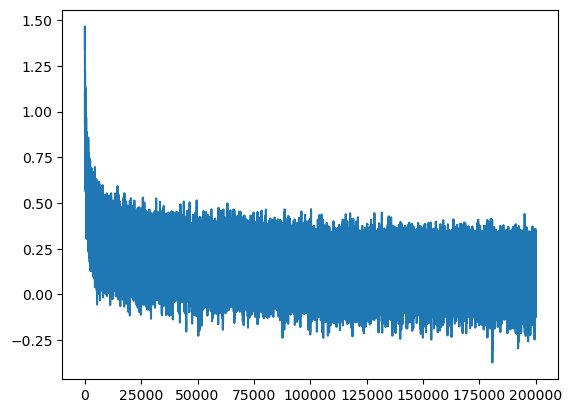

In [23]:
# German model modified to generate Spanish names
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# Download dataset from GitHub and load it into a list of words
# This dataset contains Spanish names that will be used to train the German model
!curl -o spanish_names.csv https://raw.githubusercontent.com/AntonioCorderoBrummer/Ex2-sample/refs/heads/main/Ex2sample.csv
words = open('spanish_names.csv', 'r').read().splitlines()

# Extract unique characters from the dataset and create mappings
chars = sorted(list(set(''.join(words))))  # Get unique characters from all names
stoi = {s:i+1 for i,s in enumerate(chars)}  # Mapping from characters to indices
stoi['.'] = 0  # Assign 0 to the end-of-word marker
itos = {i:s for s,i in stoi.items()}  # Reverse mapping from indices to characters
print(itos)

block_size = 4  # Number of previous characters used as context (4-gram model)

# Function to build the dataset (X: input context, Y: target character)
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # Initialize context with padding (0s)
        for ch in w + '.':  # Append '.' at the end of each word to indicate termination
            ix = stoi[ch]  # Convert character to index
            X.append(context)  # Store current context as input
            Y.append(ix)  # Store next character as the target output
            context = context[1:] + [ix]  # Update context by shifting left, maintaining window size
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)  # Print dataset dimensions
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # Shuffle words to randomize training data order
n1 = int(0.8*len(words))  # 80% for training
n2 = int(0.9*len(words))  # 10% for validation, 10% for test

# Split dataset into training, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Initialize model parameters
g = torch.Generator().manual_seed(2147483647)  # Set a fixed seed for reproducibility
C = torch.randn((len(chars) + 1, 10), generator=g)  # Character embedding matrix
W1 = torch.randn((block_size * 10, 200), generator=g)  # First layer weights
b1 = torch.randn(200, generator=g)  # First layer biases
W2 = torch.randn((200, len(chars) + 1), generator=g)  # Second layer weights
b2 = torch.randn(len(chars) + 1, generator=g)  # Second layer biases
parameters = [C, W1, b1, W2, b2]  # Store all model parameters in a list for easy manipulation

# Enable gradients for training
for p in parameters:
    p.requires_grad = True  # Allow PyTorch to track gradients for optimization

lre = torch.linspace(-3, 0, 1000)  # Learning rate exploration range (log scale)
lrs = 10**lre  # Convert to logarithmic scale
lri = []
lossi = []
stepi = []

# Training loop
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Sample 32 random training examples per batch
    emb = C[Xtr[ix].clamp(0, C.shape[0] - 1)]  # Retrieve embeddings, ensuring valid indices
    h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1)  # Apply first layer transformation with tanh activation
    logits = h @ W2 + b2  # Compute logits for predicting the next character
    loss = F.cross_entropy(logits, Ytr[ix].clamp(0, C.shape[0] - 1))  # Compute loss (categorical cross-entropy)

    for p in parameters:
        p.grad = None  # Reset gradients before each backpropagation step
    loss.backward()  # Compute gradients using backpropagation
    
    lr = 0.1 if i < 100000 else 0.01  # Adjust learning rate dynamically (higher initially, lower later)
    for p in parameters:
        p.data += -lr * p.grad  # Update parameters using gradient descent

    stepi.append(i)
    lossi.append(loss.log10().item())  # Store loss for visualization

plt.plot(stepi, lossi)  # Plot training loss over time

# Name generation loop - generates 20 Spanish names
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # Start with empty context
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits / 0.7, dim=1)  # Adjust temperature to control randomness
        ix = torch.multinomial(probs, num_samples=1).item()  # Sample next character probabilistically
        context = context[1:] + [ix]  # Update context with new character
        out.append(ix)
        if ix == 0 or len(out) > 12:  # Stop generation if '.' is reached or name is too long
            break
    
    print(''.join(itos[i] for i in out))  # Convert indices back to characters and print name